-------- > epoch 1:  coût moyen 0.45849518256646926
-------- > epoch 2:  coût moyen 0.2290519839055682
-------- > epoch 3:  coût moyen 0.15856864513917934
-------- > epoch 4:  coût moyen 0.11548146708180859
-------- > epoch 5:  coût moyen 0.08139676763370403
-------- > epoch 6:  coût moyen 0.05767966059154295
-------- > epoch 7:  coût moyen 0.0384106565681048
-------- > epoch 8:  coût moyen 0.025860293733159654
-------- > epoch 9:  coût moyen 0.019153242782821652
-------- > epoch 10:  coût moyen 0.010262858137889984


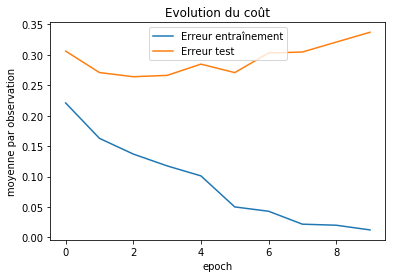

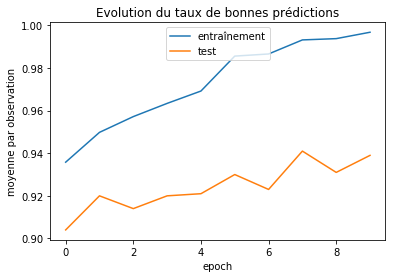

Classe de l'image 0 : [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Prédiction softmax: [array([[3.83281821e-10, 4.12734164e-15, 5.04718578e-09, 4.33325829e-02,
        1.10580565e-15, 9.56667359e-01, 2.27870377e-11, 3.24513795e-08,
        2.00691923e-08, 7.02855787e-13]])]


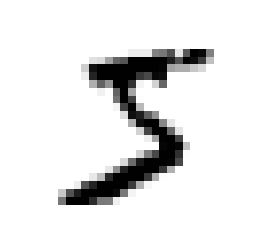

Classe de l'image 1 : [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Prédiction softmax: [array([[9.99999983e-01, 1.47122439e-16, 9.97491456e-09, 1.27063812e-10,
        1.86583082e-16, 1.18592618e-11, 6.04259348e-12, 5.83539281e-11,
        7.00136038e-09, 1.19311726e-10]])]


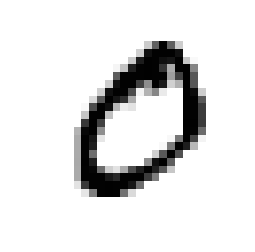

Classe de l'image 2 : [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Prédiction softmax: [array([[2.62463781e-13, 2.04387145e-10, 2.79512706e-07, 1.40755189e-09,
        9.99999716e-01, 1.46723909e-13, 4.75692186e-13, 1.30217428e-13,
        2.85949521e-11, 3.12285709e-09]])]


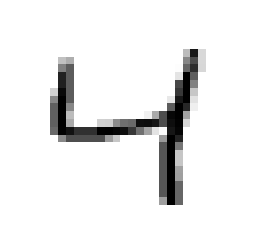

In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
# Implémentation d'un RNA par couche
# Jout de Couche convolution
# Exemple avec MNIST

import numpy as np
np.random.seed(42) # pour reproduire les mêmes résultats
import random
random.seed(42)
import matplotlib.pyplot as plt
import matplotlib as mpl

class Couche:
    """ Classe abstraite qui représente une couche du RNA
        X:  np.array 2D de taille (1,n), entrée de la couche 
        Y: np.array 2D de taille (1,m), sortie de la couche
    """

    def propager_une_couche(self,X):
        """ Calculer la sortie Y pour une valeur de X
        
        X : vecteur des variables prédictives
        Les valeurs de X et Y sont stockées pour les autres traitements.
        """

    def retropropager_une_couche(self,dJ_dY,taux,trace=False):
        """ Calculer les dérivées par rapport à X et les autres paramètres à partir de dJ_dY
        et mettre à jour les paramètres de la couche selon le taux spécifié.
        
        dJ_dY : np.array(1,m), dérivées de J par rapport à la sortie Y
        taux : float, le taux dans la descente de gradiant
        retourne la dérivée de J par rapport à X
        """

class CoucheDenseLineaire(Couche):
    """ Couche linéaire dense. Y=WX+B
    """
    def __init__(self,n,m,init_W=None,init_B=None):
        """ Initilalise les paramètres de la couche. W et B sont initialisés avec init_W et init_B lorsque spécifiés.
        Sinon, des valeurs aléatoires sont générés pour W une distribution normale et B est initialisée avec des 0 
        si les paramètres init_W et init_B ne sont pas spécifiés.
        L'initialization He est employée pour W
        n : int, taille du vecteur d'entrée X
        m : int, taille du vecteur de sortie Y
        init_W : np.array, shape(n,m), valeur initiale optionnelle de W
        init_B : np.array, shape(1,m), valeur initial optionnelle de B
        """
        if init_W is None :
            # Initialization He
            self.W = np.random.randn(n,m) * np.sqrt(2/n) 
        else:
            self.W = init_W
        if init_B is None :
            self.B = np.zeros((1,m))
        else:
            self.B = init_B

    def propager_une_couche(self,X):
        """ Fait la propagation de X et retourne Y=WX+B. 
        """
        self.X = X
        self.Y = self.B + np.dot(self.X,self.W)
        return self.Y

    def retropropager_une_couche(self,dJ_dY,taux,trace=False):
        """ Calculer les dérivées dJ_dW,dJ_dB,dJ_dX pour une couche dense linéaire et
        mettre à jour les paramètres selon le taux spécifié
        
        dJ_dY : np.array(1,2), dérivées de J par rapport à la sortie Y
        taux : float, le taux dans la descente de gradiant
        retourne la dérivée de J par rapport à X
        """
        dJ_dW = np.dot(self.X.T,dJ_dY)
        dJ_dB = dJ_dY
        dJ_dX = np.dot(dJ_dY,self.W.T)
        if trace:
            print("dJ_dW:",dJ_dW)
            print("dJ_dB:",dJ_dB)
            print("dJ_dX:",dJ_dX)
        # Metre à jour les paramètres W et B
        self.W -= taux * dJ_dW
        self.B -= taux * dJ_dB
        if trace:
            print("W modifié:",self.W)
            print("B modifié:",self.B)
        return dJ_dX

    
class CoucheActivation(Couche):
    """ Couche d'activation selon une fonction spécifiée dans le constructeur
    """
    def __init__(self,fonction_activation,derivee):
        """ Initialise la fonction_activation ainsi que la dérivée
        fonction_activation: une fonction qui prend chacune des valeurs de X et 
        retourne Y=fonction_activation(X)
        derivee: une fonction qui calcule la dérivée la fonction_activation
        """
        self.fonction_activation = fonction_activation
        self.derivee = derivee

    def propager_une_couche(self,X):
        """ Retourne Y=fonction_activation(X)
        """
        self.X = X
        self.Y = self.fonction_activation(self.X)
        return self.Y

    def retropropager_une_couche(self,dJ_dY,taux,trace=False):
        """ Retourne la dérivée de la fonction d'activation par rapport l'entrée X
        Le taux n'est pas utilisé parce qu'il n'y a pas de paramètres à modifier dans ce genre de couche
        """
        return self.derivee(self.X) * dJ_dY

class CoucheSoftmax(Couche):
    """ Couche d'activation softmax
    """
    def __init__(self,n):
        """
        n: nombre d'entrées et de sorties
        """
        self.n = n

    def propager_une_couche(self,X):
        """ Calcule les activations softmax pour chacunes de entrées xi
        """
        self.X = X
        X_decale = X-np.max(X) # Pour la stabilité numérique, les valeurs sont décalées de max(X)
        exponentielles = np.exp(X_decale)
        self.Y = exponentielles / np.sum(exponentielles)
        return self.Y

    def retropropager_une_couche(self,dJ_dY,taux,trace=False):
        """ Retourne la dérivée de la fonction d'activation par rapport l'entrée X
        Le taux n'est pas utilisé parce qu'il n'y a pas de paramètres à modifier dans ce genre de couche
        """
        return np.dot(dJ_dY,self.Y.T*(np.identity(self.n)-self.Y))
    
def correlation(X,F):
    """ Calculer la corrélation discrète valide entre X et F
    X : np.array 2d
    F : np.array 2d de taille inférieure à X """
    largeur_Y = X.shape[0]-F.shape[0]+1
    hauteur_Y = X.shape[1]-F.shape[1]+1
    Y=np.zeros((largeur_Y,hauteur_Y))
    for i in range(largeur_Y):
        for j in range(hauteur_Y):
            Y[i,j] = np.sum(X[i:i+F.shape[0],j:j+F.shape[1]]*F)
    return Y

def convolution_pleine(X,F):
    """ Calculer la corrélation discrète pareille entre X et F
    X : np.array 2d
    F : np.array 2d de taille inférieure à X, taille impaire par hypothèse """

    X_plus_bordure = np.vstack((np.zeros((F.shape[0]-1,X.shape[1])),
                                X,np.zeros((F.shape[0]-1,X.shape[1]))))
    X_plus_bordure = np.hstack((np.zeros((X_plus_bordure.shape[0],F.shape[1]-1)),
                                X_plus_bordure,np.zeros((X_plus_bordure.shape[0],F.shape[1]-1))))
    largeur_Y = X_plus_bordure.shape[0]-F.shape[0]+1
    hauteur_Y = X_plus_bordure.shape[1]-F.shape[1]+1
    Y=np.zeros((largeur_Y,hauteur_Y))
    F_inverse=np.zeros_like(F)
    for i in range(F.shape[0]):
        for j in range(F.shape[1]):
            F_inverse[F.shape[0]-i-1,F.shape[1]-j-1]= F[i,j]
    for i in range(largeur_Y):
        for j in range(hauteur_Y):
            Y[i,j] = np.sum(X_plus_bordure[i:i+F_inverse.shape[0],j:j+F_inverse.shape[1]]*F_inverse)
    return Y


class CoucheConvolution(Couche):
    """ Couche convolution qui calcule en réalité la corrélation avec les filtres F """

    def __init__(self,forme_X , forme_filtre, profondeur_Y):
        """ 
        forme_X = (largeur X, hauteur X, profondeur X)
        forme_filtre = (largeur filtre, hauteur filtre)
        profondeur_Y = profondeur de Y (nombre de filtres de la couche)"""
        self.forme_X = forme_X
        self.profondeur_X = forme_X[2]
        self.forme_filtre = forme_filtre
        self.profondeur_Y = profondeur_Y
        self.forme_Y = (forme_X[0]-forme_filtre[0]+1, forme_X[1]-forme_filtre[1]+1, profondeur_Y)
        self.F = np.random.rand(forme_filtre[0], forme_filtre[1], self.profondeur_X, profondeur_Y) - 0.5
        self.B = np.random.rand(profondeur_Y) - 0.5

    def propager_une_couche(self, X):
        self.X = X
        self.Y = np.zeros(self.forme_Y)
        for indice_profondeur_Y in range(self.profondeur_Y):
            for indice_profondeur_X in range(self.profondeur_X):
                self.Y[:,:,indice_profondeur_Y] += correlation(self.X[:,:,indice_profondeur_X], 
                      self.F[:,:,indice_profondeur_X,indice_profondeur_Y]) +self.B[indice_profondeur_Y]
        return self.Y

    def retropropager_une_couche(self, dJ_dY, taux, trace=False):
        """Calculer les gradiants pour F, B et X de la couche par rapport à J """
        dJ_dX = np.zeros(self.forme_X)
        dJ_dF = np.zeros((self.forme_filtre[0], self.forme_filtre[1], self.profondeur_X, self.profondeur_Y))
        dB = np.zeros(self.profondeur_Y)
        for indice_profondeur_Y in range(self.profondeur_Y):
            for indice_profondeur_X in range(self.profondeur_X):
                dJ_dX[:,:,indice_profondeur_X] += convolution_pleine(dJ_dY[:,:,indice_profondeur_Y], self.F[:,:,indice_profondeur_X,indice_profondeur_Y])
                dJ_dF[:,:,indice_profondeur_X,indice_profondeur_Y] = correlation(self.X[:,:,indice_profondeur_X], dJ_dY[:,:,indice_profondeur_Y])
            dB[indice_profondeur_Y] = np.sum(dJ_dY[:,:,indice_profondeur_Y])
        self.F -= taux*dJ_dF
        self.B -= taux*dB
        return dJ_dX    
    
class CoucheApplatissement(Couche):
    """Produire une forme applatie de l'entrée X"""
    def propager_une_couche(self, X):
        self.X = X
        self.Y = X.reshape((1,-1))
        return self.Y

    def retropropager_une_couche(self, dJ_dY, taux, trace=False):
        return dJ_dY.reshape(self.X.shape)

def erreur_quadratique(y_prediction,y):
    """ Retourne l'erreur quadratique entre la prédiction y_prediction et la valeur attendue y
    """ 
    return np.sum(np.power(y_prediction-y,2))

def d_erreur_quadratique(y_prediction,y):
    return 2*(y_prediction-y)

def entropie_croisee(y_prediction,y):
    """ Retourne l'entropie croisée entre la prédiction y_prediction et la valeur attendue y
    """ 
    return -np.sum(y*np.log(y_prediction))

def d_entropie_croisee(y_prediction,y):
    return -(y/y_prediction)

class ReseauMultiCouches:
    """ Réseau mutli-couche formé par une séquence de Couches
    
    couches : liste de Couches du RNA
    cout : fonction qui calcule de cout J
    derivee_cout: dérivée de la fonction de cout
    """
    def __init__(self):
        self.couches = []
        self.cout = None
        self.derivee_cout = None

    def ajouter_couche(self,couche):
        self.couches.append(couche)

    def specifier_J(self,cout,derivee_cout):
        """ Spécifier la fonction de coût J et sa dérivée
        """
        self.cout = cout
        self.derivee_cout = derivee_cout

    def propagation_donnees_X(self,donnees_X,trace=False):
        """ Prédire Y pour chacune des observations dans donnees_X)
        donnees_X : np.array 3D des valeurs de X pour chacune des observations
            chacun des X est un np.array 2D de taille (1,n)
        """
        nb_observations = len(donnees_X)
        predictions_Y = []
        for indice_observation in range(nb_observations):
            # XY_propage : contient la valeur de X de la couche courante qui correspond 
            # à la valeur de Y de la couche précédente
            XY_propage = donnees_X[indice_observation]
            if trace: 
                print("Valeur de X initiale:",XY_propage)
            for couche in self.couches:
                XY_propage = couche.propager_une_couche(XY_propage)
                if trace: 
                    print("Valeur de Y après propagation pour la couche:",XY_propage)
            predictions_Y.append(XY_propage)

        return predictions_Y

    def metriques(self, donnees_X,donnees_Y):
        """Retourne le cout moyen, la proportion de bons résultats
        Choisit l'indice de la classe dont l'activation est la plus grande"""
        erreur_quadratique = 0
        nb_correct = 0
        predictions_Y=self.propagation_donnees_X(donnees_X)
        for indice in range(len(donnees_Y)):
            erreur_quadratique += self.cout(predictions_Y[indice],donnees_Y[indice])
            classe_predite = np.argmax(predictions_Y[indice])
            if donnees_Y[indice][0,classe_predite] == 1:
                nb_correct+=1
        return (erreur_quadratique/len(donnees_Y),nb_correct/len(donnees_Y))

    def entrainer_descente_gradiant_stochastique(self,donnees_ent_X,donnees_ent_Y,donnees_test_X,donnees_test_Y,
                                                 nb_epochs,taux,trace=False,graph_cout=False):
        """ Entrainer le réseau par descente de gradiant stochastique (une observation à la fois)
        
        donnees_ent_X : np.array 3D des valeurs de X pour chacune des observations d'entrainement
            chacun des X est un np.array 2D de taille (1,n)
        donnees_ent_Y : np.array 3D des valeurs de Y pour chacune des observations d'entrainement
            chacun des Y est un np.array 2D de taille (1,m)
        donnees_test_X : np.array 3D des valeurs de X pour chacune des observations de test
            chacun des X est un np.array 2D de taille (1,n)
        donnees_test_Y : np.array 3D des valeurs de Y pour chacune des observations de test
            chacun des Y est un np.array 2D de taille (1,m)
        nb_epochs : nombre de cycle de passage sur les données d'entainement
        taux : taux dans la descente de gradiant
        trace : Boolean, True pour afficher une trace des calculs effectués sur les paramètres
        graph_cout : Boolean, True pur afficher un graphique de l'évolution du coût
        """
        nb_observations = len(donnees_ent_X)
        if graph_cout :
            liste_cout_moyen_ent = []
            liste_ok_ent = []
            liste_cout_moyen_test = []
            liste_ok_test = []

        # Boucle d'entrainement principale, nb_epochs fois
        for cycle in range(nb_epochs):
            cout_total = 0
            # Descente de gradiant stochastique, une observation à la fois
            for indice_observation in range(nb_observations):
                # Propagation avant pour une observation X
                # XY_propage : contient la valeur de X de la couche courante qui correspond 
                # à la valeur de Y de la couche précédente
                XY_propage = donnees_ent_X[indice_observation]
                if trace: 
                    print("Valeur de X initiale:",XY_propage)

                for couche in self.couches:
                    XY_propage = couche.propager_une_couche(XY_propage)
                    if trace: 
                        print("Valeur de Y après propagation pour la couche:",XY_propage)

                # Calcul du coût pour une observation
                cout_total += self.cout(XY_propage,donnees_ent_Y[indice_observation])

                # Rétropropagation pour une observation
                # dJ_dX_dJ_dY représente la valeur de la dérivée dJ_dX de la couche suivante
                # qui correspond à dJ_dY de la couche en cours de traitement
                dJ_dX_dJ_dY = self.derivee_cout(XY_propage,donnees_ent_Y[indice_observation])
                if trace :
                    print("dJ_dY pour la couche finale:",dJ_dX_dJ_dY)
                for couche in reversed(self.couches):
                    dJ_dX_dJ_dY = couche.retropropager_une_couche(dJ_dX_dJ_dY,taux,trace)

            # Calculer et afficher le coût moyen pour une epoch
            cout_moyen = cout_total/nb_observations
            if graph_cout:
                print(f'-------- > epoch {cycle+1}:  coût moyen {cout_moyen}')
                cout_ent,ok_ent = self.metriques(donnees_ent_X,donnees_ent_Y)
                cout_test,ok_test = self.metriques(donnees_test_X,donnees_test_Y)
                liste_cout_moyen_ent.append(cout_ent)
                liste_ok_ent.append(ok_ent)
                liste_cout_moyen_test.append(cout_test)
                liste_ok_test.append(ok_test)
                
            
        # Affichage du graphique d'évolution de l'erreur quadratique
        if graph_cout:
            plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
            plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_test,label='Erreur test')
            plt.title("Evolution du coût")
            plt.xlabel('epoch')
            plt.ylabel('moyenne par observation')
            plt.legend(loc='upper center')
            plt.show()
            
            plt.plot(np.arange(0,nb_epochs),liste_ok_ent,label='entraînement')
            plt.plot(np.arange(0,nb_epochs),liste_ok_test,label='test')
            plt.title("Evolution du taux de bonnes prédictions")
            plt.xlabel('epoch')
            plt.ylabel('moyenne par observation')
            plt.legend(loc='upper center')
            plt.show()

def tanh(x):
    return np.tanh(x)

def derivee_tanh(x):
    return 1-np.tanh(x)**2

def sigmoide(x):
    return 1.0/(1.0+np.exp(-x))

def derivee_sigmoide(x):
    return sigmoide(x)*(1-sigmoide(x))

def relu(x):
    return np.maximum(x,0)

def derivee_relu(x):
    return np.heaviside(x,1)

def bitmap(classe):
    """ Representer l'entier de classe par un vecteur bitmap (10,1) 
    classe : entier (entre 0 et 9 qui représente la classe de l'observation"""
    e = np.zeros((1,10))
    e[0,classe] = 1.0
    return e

# Chargement des données de MNIST
import pickle, gzip

fichier_donnees = gzip.open(r"mnist.pkl.gz", 'rb')
donnees_ent, donnees_validation, donnees_test = pickle.load(fichier_donnees, encoding='latin1')
fichier_donnees.close()
    
donnees_ent_X = donnees_ent[0].reshape((50000,28,28,1))
donnees_ent_Y = [bitmap(y) for y in donnees_ent[1]] # Encodgae bitmap de l'entier (one hot encoding)
donnees_test_X = donnees_test[0].reshape((10000,28,28,1))
donnees_test_Y = [bitmap(y) for y in donnees_test[1]] # Encodgae bitmap de l'entier (one hot encoding)

# Définir l'architecture du RNA 
un_RNA = ReseauMultiCouches()
un_RNA.specifier_J(entropie_croisee,d_entropie_croisee)
un_RNA.ajouter_couche(CoucheConvolution((28,28,1),(3,3),5))
un_RNA.ajouter_couche(CoucheActivation(relu,derivee_relu))
un_RNA.ajouter_couche(CoucheApplatissement())
un_RNA.ajouter_couche(CoucheDenseLineaire(26*26*5,10))
un_RNA.ajouter_couche(CoucheSoftmax(10))

# Entrainer le RNA
un_RNA.entrainer_descente_gradiant_stochastique(donnees_ent_X[:5000],donnees_ent_Y[:5000],donnees_test_X[:1000],donnees_test_Y[:1000],
                                                nb_epochs=10,taux=0.01,trace = False, graph_cout = True)

for i in range(3):
    print("Classe de l'image",i,":",donnees_ent_Y[i])
    print("Prédiction softmax:",un_RNA.propagation_donnees_X(donnees_ent_X[i:i+1]))
    plt.imshow(donnees_ent_X[i].reshape(28,28), cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()